# Setup

## Imports 

In [1]:
import gym
from vaiutils import plot_image, path_consts, smooth_plot
from tqdm import tqdm_notebook
from os.path import exists

Torch Modules

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Define useful variables and functions

In [3]:
for k, v in path_consts('Pong-PG'):
    exec(k + '=v')

In [4]:
env = gym.make('Pong-v0')

[2017-09-11 12:21:19,610] Making new env: Pong-v0


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Returns the normalized (modified) action

In [6]:
def norm_action(action):
    if action == 0 or action == 1:
        return 0
    elif action == 2 or action == 4:
        return 1
    elif action == 3 or action == 5:
        return 2

Returns the actions in the default (game) space

In [7]:
def denorm_action(action):
    if action == 0:
        return 0
    else:
        return action + 1

Returns the meaning of the normalized action

In [8]:
def meaning(normed_action):
    if normed_action == 0:
        return 'Nothing'
    elif normed_action == 1:
        return 'Up'
    elif normed_action == 2:
        return 'Down'

Refines the observation to essential features

In [9]:
def refine_observation(observation):
    res_img = observation[34:192, 1:-1].mean(2)
    res_img[res_img < 100] = 0
    res_img[res_img > 100] = 255

    white_pos = np.where(res_img == 255)
    l_cols = (white_pos[1] > 14) & (white_pos[1] < 19)
    if np.any(l_cols):
        l_y = white_pos[0][np.where(l_cols)].mean()
    else:
        l_y = 0

    r_cols = (white_pos[1] > 138) & (white_pos[1] < 143)
    if np.any(r_cols):
        r_y = white_pos[0][np.where(r_cols)].mean()
    else:
        r_y = 0

    b_cols = ~l_cols & ~r_cols
    if np.any(b_cols):
        b_x = white_pos[1][np.where(b_cols)].mean()
        b_y = white_pos[0][np.where(b_cols)].mean()
    else:
        b_x = 0
        b_y = 0

    return np.array([l_y, r_y, b_x, b_y]) / 79 - 1

Returns an image representation of the refined observation

In [10]:
def paint_observation(refined_observation):
    obs = (refined_observation + 1) * 79
    obs_centre = np.ceil(obs).astype('int')

    img = np.zeros((158, 158))

    l_y_l, r_y_l, b_x_l, b_y_l = np.maximum(0, obs_centre - [8, 8, 1, 2])
    l_y_h, r_y_h, b_x_h, b_y_h = np.minimum(158, obs_centre + [8, 8, 1, 2])

    img[l_y_l:l_y_h, 15:19] = 255
    img[r_y_l:r_y_h, 139:143] = 255
    img[b_y_l:b_y_h, b_x_l:b_x_h] = 255
    return img

# Create Network

In [75]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        #self.conv1 = nn.Conv2d(3, 4, (3,3), padding=1, stride=2)
        #self.conv2 = nn.Conv2d(4, 8, (3,3), padding=1, stride=2)
        #self.conv3 = nn.Conv2d(8, 16, (3,3), padding=1, stride=2)
        #self.conv4 = nn.Conv2d(16, 32, (3,3), padding=1, stride=2)
        #self.conv5 = nn.Conv2d(32, 64, (3,3), padding=1, stride=2)
        #self.fc1 = nn.Linear(2, 1)#nn.Linear(64*7*5, 3)
        self.fc2 = nn.Linear(4, 3, bias=False)
        
    def forward(self, x):
        #print(x.size())
        #x = F.relu(self.conv1(x))
        #print(x.size())
        #x = F.relu(self.conv2(x))
        #print(x.size())
        #x = F.relu(self.conv3(x))
        #print(x.size())
        #x = F.relu(self.conv4(x))
        #print(x.size())
        #x = F.relu(self.conv5(x))
        #print(x.size())
        #x = F.relu(self.fc1(x.view(-1,4)))#F.softmax(self.fc1(x.view(-1,64*7*5)))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        return x.squeeze()

In [105]:
policy_net=PolicyNet().cuda()
policy_optimizer = optim.SGD(policy_net.parameters(), lr=1e-3)

In [106]:
list(policy_net.parameters())

[Parameter containing:
 -0.4150 -0.2023 -0.2794 -0.4473
  0.1899 -0.2651 -0.4665  0.3427
  0.0820 -0.1526  0.4981  0.2589
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)]]

# Train Network

In [111]:
history = {'reward':[]}

In [107]:
def optimize(episodes=1, discount=1e-2):
    for episode in tqdm_notebook(range(episodes)):
        observation = env.reset()
        actions = []
        actions_taken = []
        reward = 0
        points_played = 0
        done = False
        steps=0
        while not done:
            #actions.append(policy_net(Variable(torch.FloatTensor(np.stack([np.transpose(observations[-1], [2,0,1]).astype('float64')]))).cuda()))
            actions.append(policy_net(Variable(torch.FloatTensor(refine_observation(observation))).cuda()))
            actions_taken.append(np.random.choice(range(0,3),p=F.softmax(actions[-1]).data.cpu().numpy()))
            #actions.append(policy_net(Variable(torch.FloatTensor(refine_observation(observations[-1])[1::2])).cuda()))
            observation, r, done, _ = env.step(denorm_action((actions_taken[-1])))
            if r!=0:
                reward += r# * (1 + 1/(1+steps))
                steps=0
            steps +=1
            
            if r != 0:
                for t, act in enumerate(actions[-1:1:-1]):
                    policy_optimizer.zero_grad()
                    back_grads = torch.zeros(3)
                    back_grads[actions_taken[-1-t]] = -r * (1-discount)**t
                    act.backward(back_grads.cuda())
                    policy_optimizer.step()
                actions = []
                points_played+=1
        
        history['reward'].append(reward / points_played)

In [115]:
optimize(60)

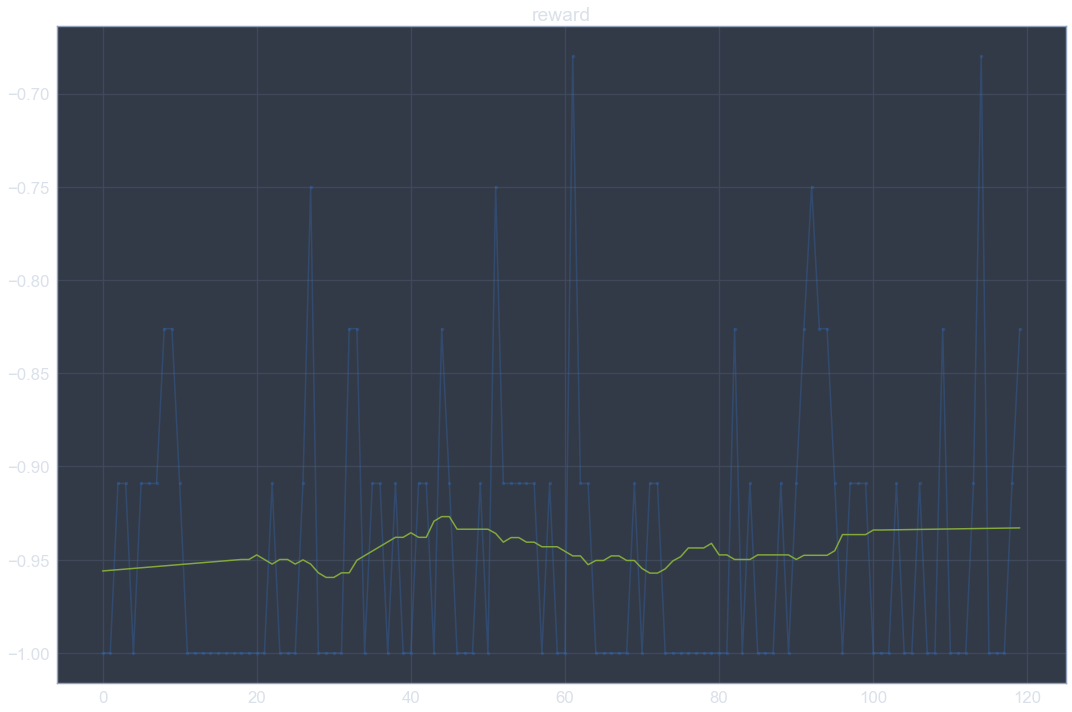

In [116]:
smooth_plot(history, remove_outlier=False)

# Test Model

In [45]:
def run_env(num_points=-1, flags=[]):
    points_played = 0
    reward = 0

    observation = env.reset()
    while True:
        if 'render' in flags:
            env.render()
        
        #action = policy_net(Variable(torch.FloatTensor(np.stack([np.transpose(observation, [2,0,1]).astype('float64')]))).cuda())
        action = policy_net(Variable(torch.FloatTensor(refine_observation(observation))).cuda())
        #print(action.data.cpu().numpy())
        action = np.random.choice(range(0,3),p=F.softmax(action).data.cpu().numpy())
        #action = (action.data.cpu().numpy() > 0) + 1
            
        observation, r, done, _ = env.step(denorm_action(action))
        reward += r
        
        if 'verbose' in flags:
            print("Point:{}, Reward: {}, Action: {}".format(
                1 + points_played, np.round(reward / (1 + points_played), 2), meaning(action), end='\r', flush=True))
        if r != 0:
            points_played += 1
            if points_played == num_points:
                break

        if done:
            break

    return reward / points_played

In [ ]:
run_env(5, 'render')

# Predictor Network

## Prepare Data

In [ ]:
def get_observations(t=None):
    env.reset()
    done = False
    observations = []
    rewards = []
    actions = []
    while True:
        action = randint(1, 3)
        observation, reward, done, _ = env.step(denorm_action(action))
        observations.append(refine_observation(observation))
        rewards.append(reward)
        actions.append(action - 1)
        if done:
            if t is None:
                break
            elif len(observations) > t:
                break
            else:
                env.reset()
    return observations, rewards, actions

In [ ]:
train_observations, _, train_actions = get_observations(1e4)
train_actions = to_categorical(train_actions)
y_train = np.stack([np.stack(train_observations[i])
                    for i in range(5, len(train_observations) - 1)])
train_observations = np.stack(
    [np.hstack([obs, act]) for obs, act in zip(train_observations, train_actions)])
x_train = np.stack([train_observations[i:i + 5]
                    for i in range(len(train_observations) - 5 - 1)])

In [ ]:
valid_observations, _, valid_actions = get_observations(
    int(0.2 * len(train_observations)))
valid_actions = to_categorical(valid_actions)
y_valid = np.stack([np.stack(valid_observations[i])
                    for i in range(5, len(valid_observations) - 1)])
valid_observations = np.stack(
    [np.hstack([obs, act]) for obs, act in zip(valid_observations, valid_actions)])
x_valid = np.stack([valid_observations[i:i + 5]
                    for i in range(len(valid_observations) - 5 - 1)])

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_valid.shape, y_valid.shape

## Create Network

In [ ]:
clear_session()
predictor = Sequential([BatchNormalization(axis=1, input_shape=(5, 6)),
                        LSTM(16),
                        Dense(4, activation='tanh')])
predictor.summary()

In [ ]:
predictor.compile('adam', 'mse')

## Train Network

In [ ]:
def fit_predictor(epochs=1, lr=1e-3):
    if exists(DIR_OUTPUT + '/predictor.h5'):
        predictor.load_weights(DIR_OUTPUT + '/predictor.h5')

    predictor.optimizer.lr = lr
    hist = predictor.fit(x_train, y_train, batch_size=256, epochs=epochs, verbose=0, callbacks=[
        TQDMNotebookCallback()], validation_data=(x_valid, y_valid))
    predictor.save_weights(DIR_OUTPUT + '/predictor.h5')
    return hist

In [ ]:
hist = fit_predictor(60, 1e-4)

In [ ]:
smooth_plot(hist.history, flags='retain')
np.array(hist.history['loss']
         )[-10:].mean(), np.array(hist.history['val_loss'])[-10:].mean()

## Test Network

In [ ]:
n = 50
m = 100

In [ ]:
sample_observations, _, sample_actions = get_observations(n + m)

In [ ]:
sample_actions = to_categorical(sample_actions)
sample_observations = [np.hstack([obs, act]) for obs, act in zip(
    sample_observations, sample_actions)]

In [ ]:
predicted_observations = sample_observations[:n]

In [ ]:
for _ in range(m):
    predicted_observation = np.zeros(6)
    predicted_observation[:4] = predictor.predict(
        np.stack([np.stack(predicted_observations[-5:])])).squeeze()
    predicted_observation[randint(4, 6)] = 1
    predicted_observations.append(predicted_observation)

In [ ]:
gifsave(DIR_OUTPUT + '/future.gif', [merge(np.stack([paint_observation(obs[:4]), paint_observation(
    pred[:4])]), (2, 1)).squeeze() for obs, pred in zip(sample_observations, predicted_observations)], 'gif')

# Reward Network

## Prepare Data

In [ ]:
def prepare_reward_data(t=None):
    train_observations, train_rewards, train_actions = get_observations(t)
    train_actions = to_categorical(train_actions)
    train_observations = np.stack([np.hstack([obs, act]) for obs, act in zip(train_observations, train_actions)])
    train_rewards = np.stack(train_rewards)

    train_reward_neg_idx = np.where(train_rewards == -1)[0]
    train_reward_neut_idx = np.where(train_rewards != -1)[0]
    train_reward_neut_idx = train_reward_neut_idx[randint(
        5, len(train_reward_neut_idx - 5), len(train_reward_neg_idx))]

    
    x_train_neg = np.stack([np.stack(train_observations[i - 4:i + 1])
                            for i in train_reward_neg_idx])
    x_train_neut = np.stack([np.stack(train_observations[i - 4:i + 1])
                             for i in train_reward_neut_idx])
    x_train = np.vstack([x_train_neg, x_train_neut])

    y_train = np.zeros((len(x_train_neg) * 2))
    y_train[:len(x_train_neg)] = 1

    return x_train, y_train

In [ ]:
x_train, y_train = prepare_reward_data(1e4)

In [ ]:
x_valid, y_valid = prepare_reward_data(2e3)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_valid.shape, y_valid.shape

## Create Network

In [ ]:
pred_input = predictor.input
hidden = predictor.layers[1].output
pred_reward = Dense(1, activation='sigmoid')(hidden)
rewarder = Model(pred_input, pred_reward)

for layer in rewarder.layers[:-1]:
    layer.trainable = False
    
rewarder.summary()

In [ ]:
rewarder.compile('adam', 'binary_crossentropy')

## Train Network

In [ ]:
def fit_rewarder(epochs=1, lr=1e-3):
    if exists(DIR_OUTPUT + '/rewarder.h5'):
        rewarder.load_weights(DIR_OUTPUT + '/rewarder.h5')

    rewarder.optimizer.lr = lr
    hist = rewarder.fit(x_train, y_train, batch_size=256, epochs=epochs, verbose=0, callbacks=[
    TQDMNotebookCallback()], validation_data=(x_valid, y_valid))
    rewarder.save_weights(DIR_OUTPUT + '/rewarder.h5')
    return hist

In [ ]:
hist = fit_rewarder(250, 1e-5)

In [ ]:
smooth_plot(hist.history, flags='retain')
np.array(hist.history['loss']
         )[-10:].mean(), np.array(hist.history['val_loss'])[-10:].mean()

## Test Network

In [ ]:
n = 300

In [ ]:
sample_observations, _, sample_actions = get_observations(n)
pred_rewards = []
reward_bars = [np.zeros((3, 158))] * 4

In [ ]:
sample_actions = to_categorical(sample_actions)
sample_observations = np.stack([np.hstack([obs, act]) for obs, act in zip(sample_observations, sample_actions)])

In [ ]:
for i in range(5, n):
    pred_reward = rewarder.predict(
        np.stack([np.stack(sample_observations[i - 5:i])])).squeeze()
    pred_rewards.append(pred_reward)
    reward_bar = np.zeros((3, 158))
    reward_bar[:, :int(pred_reward * 158)] = 255
    reward_bars.append(reward_bar)

In [ ]:
plot(pred_rewards)

In [ ]:
gifsave(DIR_OUTPUT + '/reward.gif', [np.vstack([reward_bar, paint_observation(obs[:4])])
                                     for reward_bar, obs in zip(reward_bars, sample_observations)], 'gif')

# Use network to plan

In [ ]:
def get_predicted_observations(observations, num_steps=5, actions=None):
    if actions is None:
        actions = np.random.multinomial(1,[0.5]*2,num_steps)
        
    predicted_observations=observations[:]
    for i in range(num_steps):
        predicted_observation = np.zeros(6)
        predicted_observation[:4] = predictor.predict(
            np.stack([np.stack(predicted_observations[-num_steps:])])).squeeze()
        predicted_observation[-2:] = actions[i]
        predicted_observations.append(predicted_observation)
        
    return predicted_observations[-num_steps:]

In [ ]:
env.reset()
observations=[]
for _ in range(30): 
    observations.append(np.hstack([refine_observation(env.step(denorm_action(0))[0]), randint(0,1,2)]))

In [ ]:
for obs in observations[-5:]:
    plot_image(paint_observation(obs[:4]), pixel_range=(0,255))
for obs in get_predicted_observations(observations):
    plot_image(paint_observation(obs[:4]), pixel_range=(0,255))

In [ ]:
def get_policy(observations, num_steps=5, it_range=5, strength=1):
    actions = np.random.multinomial(1,[0.5]*2,num_steps).astype('float64')
    predicted_observations=get_predicted_observations(observations, num_steps, actions)
    
    input_x = rewarder.input
    pred_reward = rewarder.output
    
    loss = pred_reward[0]
    grads = K.gradients(loss, input_x)[0][0, :, :2]
    
    iterate = K.function([input_x, K.learning_phase()], [loss, grads])
    
    for _ in range(it_range):
        for i in range(num_steps):
            predicted_observations=get_predicted_observations(observations, num_steps, actions)
        loss_value, grads_value = iterate([np.stack([np.stack(predicted_observations)]), False])
        print(loss_value[0], grads_value.mean())
        actions -= grads_value * strength
        
    return actions.argmax(1)

In [ ]:
get_policy(observations)

In [ ]:
def run_env(num_points=-1, flags=[]):
    points_played = 0
    reward = 0
    start_time = time()

    observations = []
    env.reset()
    while True:
        if 'render' in flags:
            env.render()
        
        if len(observations) < 5:
            action = randint(1,3)
        else:
            action = get_policy(observations)[0]
            
        observation, r, done, _ = env.step(denorm_action(action))
        reward += r
        
        observations.append(np.hstack([refine_observation(observation), to_categorical(action-1, 2).squeeze()]))
        
        if 'verbose' in flags:
            print("Point:{}, Reward: {}, Action: {}, Time: {}s".format(
                1 + points_played, np.round(reward / (1 + points_played), 2), meaning(action), int(time() - start_time)), end='\r', flush=True)
        if r != 0:
            points_played += 1
            if points_played == num_points:
                break

        if done:
            break

    return reward / points_played

In [ ]:
run_env(1, 'verbose')